# Feature Selection
<hr style="height:1px;border:none;color:#333;background-color:#333;" />


### Basic Configuration

#### Importing Modules

In [1]:
# import modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, f_classif, mutual_info_classif, mutual_info_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, LassoCV

#### Dataframes Display Settings

In [96]:
pd.set_option('display.max_columns', None) # display all the columns of a dataframe
pd.set_option('display.max_rows', 100)     # display 100 rows of a dataframe

#### Load data

In [68]:
# Load cleaned data - see "Data Cleansing.ipynb"
dataset = pd.read_csv('../ariel/Price_Data_cleaned.csv')

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### Exploratory Data Analysis

#### Grouping Variables by Type

In [69]:
continues_variables = ['GrLivArea', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'WoodDeckSF',
                       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
                       'SalePrice', 'LotFrontage']

discrete_variables = ['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                      'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
                      'MoSold', 'YrSold']

nominal_variables = ['MSSubClass', 'Alley', 'LandContour', 'MSZoning', 'LotConfig', 'Neighborhood',
                     'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
                     'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Street', 'Heating',
                     'GarageType', 'CentralAir', 'MiscFeature', 'SaleType', 'SaleCondition']

ordinal_variables = ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                     'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC',
                     'GarageFinish', 'PavedDrive', 'Fence', 'Functional', 'BsmtFinType2', 'Electrical',
                     'BsmtFinType1','BsmtExposure', 'LandSlope', 'Utilities', 'LotShape',]


#### Remove Abnormal Sales
<br>
Only include sales that were completed under 'normal' circumstances. The other type of sales (foreclosure, short sale, etc...) only account for 6% of the observations.

In [71]:
dataset = dataset[dataset['SaleCondition']=='Normal']

In [72]:
# Drop SaleCondition and SaleType since all the sales are now 'Normal'
dataset.drop(columns='SaleCondition', inplace=True)

In [ ]:
dataset

#### Combining Number Basement Bathrooms

In [ ]:
# Combine BsmtFullBath and BsmtHalfBath
# dataset['BsmtNumBath'] = dataset['BsmtFullBath'] + dataset['BsmtHalfBath']/2
dataset.drop(columns=['BsmtFullBath','BsmtHalfBath'], inplace=True)


#### Remove Features With Less Than 10% of Observations

In [99]:
# Removing the following features since they are only present in less than 10% of the observations
((dataset.select_dtypes(['int','float'])==0).sum()/2413).sort_values(ascending=False).head(5)


PoolArea        0.996270
3SsnPorch       0.988396
LowQualFinSF    0.987153
MiscVal         0.961044
ScreenPorch     0.912143
dtype: float64

In [100]:
dataset = dataset.drop(columns=['PoolArea', '3SsnPorch', 'LowQualFinSF', 'MiscVal','ScreenPorch'], axis=1)

#### Remove Nominal Variables With Less Than 10% of Observations

In [101]:
# Removing the following categorical variables that account for less the 10% in the observations.
((dataset.select_dtypes('object')=='None').sum()/2413).sort_values(ascending=False).head(3)

PoolQC         0.996270
MiscFeature    0.960215
Alley          0.936179
dtype: float64

In [102]:
dataset = dataset.drop(columns=['PoolQC', 'MiscFeature', 'Alley'],axis=1)

#### Group Neighborhoods

In [103]:
dataset['PricePerSqFoot'] = (dataset['SalePrice'] / dataset['GrLivArea'])

In [173]:
bsmt = dataset[['Neighborhood','SalePrice','BsmtQual','OverallQual','TotRmsAbvGrd','BedroomAbvGr', 'BsmtCond','CentralAir','BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF','GrLivArea']]
bsmt_by_nb = bsmt.groupby(['Neighborhood','BsmtQual','SalePrice']).mean()

In [174]:
bsmt['PriceLivSquareFoot'] = bsmt['SalePrice'] / bsmt['GrLivArea'] #bsmt['TotalBsmtSF']

In [141]:
pd.set_option('display.max_rows', None)  
#bsmt_by_nb
bsmt[bsmt['Neighborhood']=="CollgCr"].sort_values(by="PriceBsmtSquareFoot")

,Neighborhood,SalePrice,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,PriceBsmtSquareFoot
1457,CollgCr,143500,Gd,Gd,ALQ,Unf,1072.0,1268.0,113.170347
1089,CollgCr,216837,Gd,TA,GLQ,Unf,1836.0,1860.0,116.579032
2156,CollgCr,200000,Gd,TA,GLQ,Unf,1342.0,1682.0,118.906064
570,CollgCr,110000,Gd,TA,Unf,Unf,924.0,924.0,119.047619
1448,CollgCr,124000,Gd,TA,Rec,Unf,424.0,1040.0,119.230769
1699,CollgCr,123600,Gd,TA,GLQ,Unf,402.0,990.0,124.848485
1061,CollgCr,122000,TA,TA,BLQ,Unf,253.0,969.0,125.902993
53,CollgCr,179600,Gd,TA,Unf,Unf,1422.0,1422.0,126.300985
1440,CollgCr,190000,Gd,TA,GLQ,Unf,1480.0,1500.0,126.666667
1961,CollgCr,126000,Gd,TA,GLQ,Unf,495.0,990.0,127.272727


In [187]:
# dataset['Exterior1st']
#bsmt[bsmt['Neighborhood']=="BrkSide"].groupby('BsmtFinType1').agg({"PriceBsmtSquareFoot":"mean","SalePrice":"mean"})
dataset.groupby('Exterior1st').agg({"PricePerSqFoot":"mean","SalePrice":"mean","GrLivArea":"mean"}).sort_values(by="SalePrice", ascending=False)

,PricePerSqFoot,SalePrice,GrLivArea
Exterior1st,,,
ImStucc,161.330049,262000.000000,1624.000000
PreCast,171.277997,260000.000000,1518.000000
VinylSd,130.988575,209159.823303,1607.704225
CemntBd,125.862132,198883.218391,1532.344828
BrkFace,122.489481,191030.921053,1565.894737
Plywood,119.952404,171808.333333,1488.134409
HdBoard,121.409780,163578.894207,1381.493703
BrkComm,100.381838,153000.000000,1501.200000
MetalSd,113.401255,151441.594872,1362.353846


In [113]:
# pd.DataFrame(dataset.groupby('Neighborhood').size())
dataset.

,0
Neighborhood,
Blmngtn,19
Blueste,10
BrDale,26
BrkSide,98
ClearCr,38
CollgCr,226
Crawfor,88
Edwards,155
Gilbert,130


In [123]:
f = dataset.groupby('Neighborhood').agg({"GrLivArea":"mean"}).reset_index()
#f.merge(e, left_on= "Neighborhood",right_on= Neighborhood",how='outer') )

In [124]:
f.merge(e, left_on= "Neighborhood",right_on= "Neighborhood",how='outer').sort_values(by="GrLivArea")

,Neighborhood,GrLivArea,0
13,MeadowV,1078.058824,34
2,BrDale,1109.923077,26
9,Greens,1157.250000,8
1,Blueste,1159.700000,10
22,Sawyer,1181.488889,135
3,BrkSide,1240.734694,98
11,IDOTRR,1250.661765,68
16,NPkVill,1252.045455,22
15,NAmes,1283.959494,395
7,Edwards,1302.070968,155


In [114]:
c=pd.DataFrame(dataset.groupby('Neighborhood')['PricePerSqFoot'].mean().sort_values(ascending=False)).reset_index()
d=pd.DataFrame(dataset.groupby('Neighborhood')['SalePrice'].mean().sort_values(ascending=False)).reset_index()
Neibs_comparance=pd.merge(c,d, left_on= "Neighborhood",right_on= "Neighborhood",how='outer').sort_values(by='PricePerSqFoot',ascending=False)
Neibs_comparance.merge(e, left_on= "Neighborhood",right_on= "Neighborhood",how='outer').sort_values(by='SalePrice',ascending=False)

,Neighborhood,PricePerSqFoot,SalePrice,0
9,NoRidge,132.546126,326114.298507,67
2,NridgHt,161.151366,302478.980000,100
0,GrnHill,198.656617,280000.000000,2
3,StoneBr,156.901871,276269.142857,35
4,Veenker,150.653639,255865.909091,22
5,Timber,143.459400,241773.346154,52
6,Somerst,139.441560,223900.500000,114
11,ClearCr,127.291261,216558.736842,38
15,Crawfor,118.394487,200019.000000,88
7,CollgCr,136.393226,196501.871681,226


In [104]:
pd.DataFrame(dataset.groupby('Neighborhood')['PricePerSqFoot'].mean().sort_values(ascending=False)).reset_index()

,Neighborhood,PricePerSqFoot
0,GrnHill,198.656617
1,Greens,168.835142
2,NridgHt,161.151366
3,StoneBr,156.901871
4,Veenker,150.653639
5,Timber,143.459400
6,Somerst,139.441560
7,CollgCr,136.393226
8,Blmngtn,136.369170
9,NoRidge,132.546126


In [11]:
# Grouped Neighborhoods by Price/square-foot
dict_20 = {'NoRidge':'a', 'NridgHt':'a', 'StoneBr':'a', 'GrnHill':'a',\
          'Veenker':'b','Timber':'b','Somerst':'b','Blmngtn': 'b','Greens':'b',\
           'ClearCr':'c', 'Crawfor':'c','CollgCr':'c', 'Blmngtn':'c', \
          'NAmes':'d', 'NWAmes':'d','Gilbert':'d', 'SawyerW':'d', 'Sawyer':'d','Mitchel':'d','Blueste':'d',\
          'NPkVill':'e',  'Landmrk':'e', 'Edwards':'e', 'BrkSide':'e',\
          'MeadowV':'f', 'BrDale':'f', 'IDOTRR':'f', 'OldTown':'f', 'SWISU':'f'}

# dataset.Neighborhood.replace(dict_20, inplace=True)

In [12]:
# dataset.Neighborhood.unique
dataset.Neighborhood.replace(dict_20, inplace=True)

#### Converting Ordinal Variables to Numeric

In [13]:
# Encoding Ordinal Variables
dict_1 = {'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}
dict_2 = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
dict_3 = {'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
dict_4 = {"None":0, "Unf":1, "RFn":2, "Fin":3}
dict_5 = {"N":1, "P":2, "Y":3}
dict_6 = {"None":0, "MnWw":1, "GdWo":2, "MnPrv":3, "GdPrv":4}
dict_7 = {"Sal":1, "Sev":2, "Maj2":3, "Maj1":4, "Mod":5, "Min2":6, "Min1":7, "Typ":8}
dict_8 = {"Mix":1, "FuseP":2, "FuseF":3, "FuseA":4, "SBrkr":5}
dict_9 = {"Sev":1, "Mod":2, "Gtl":3}
dict_10 = {"ELO":1, "NoSeWa":2, "NoSewr":3, "AllPub":4}
dict_11 = {"IR3":1, "IR2":2, "IR1":3, "Reg":4}

dataset.BsmtExposure.replace(dict_1, inplace=True)
dataset.ExterQual.replace(dict_2, inplace=True)
dataset.ExterCond.replace(dict_2, inplace=True)
dataset.BsmtQual.replace(dict_2, inplace=True)
dataset.BsmtCond.replace(dict_2, inplace=True)
dataset.HeatingQC.replace(dict_2, inplace=True)
dataset.KitchenQual.replace(dict_2, inplace=True)
dataset.FireplaceQu.replace(dict_2, inplace=True)
dataset.GarageQual.replace(dict_2, inplace=True)
dataset.GarageCond.replace(dict_2, inplace=True)
# dataset.PoolQC.replace(dict_2, inplace=True)
dataset.BsmtFinType1.replace(dict_3, inplace=True)
dataset.BsmtFinType2.replace(dict_3, inplace=True)
dataset.GarageFinish.replace(dict_4, inplace=True)
dataset.PavedDrive.replace(dict_5, inplace=True)
dataset.Fence.replace(dict_6, inplace=True)
dataset.Functional.replace(dict_7, inplace=True)
dataset.Electrical.replace(dict_8, inplace=True)
dataset.LandSlope.replace(dict_9, inplace=True)
dataset.Utilities.replace(dict_10, inplace=True)
dataset.LotShape.replace(dict_11, inplace=True)

#### Dummifying Nominal Variables

In [14]:
# update the nominal_variables list by removing the columns removed in the previous section
nominal_variables_updated = list(set(nominal_variables)-set(['PoolQC', 'MiscFeature', 'Alley', 'SaleCondition']))

In [15]:
# set the MSSubClass column to object, since it is a nominal variable
dataset['MSSubClass'] = dataset['MSSubClass'].astype(object)
# new dataset that will hold the encoded categorical variables + all the others
dataset_encoded = dataset.copy()
# Encode all categorical nominal variables
for column_name in nominal_variables_updated:
    dataset_encoded = pd.concat([dataset_encoded, pd.get_dummies(dataset_encoded[column_name], prefix=column_name, drop_first=True)], axis=1)
# Remove original categorical columns
dataset_encoded = dataset_encoded.drop(nominal_variables_updated, axis=1)

In [16]:
dataset_encoded

,GrLivArea,SalePrice,LotFrontage,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,Electrical,1stFlrSF,2ndFlrSF,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,Fence,MoSold,YrSold,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Street_Pave,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,LandContour_HLS,LandContour_Low,LandContour_Lvl,CentralAir_Y,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,Neighborhood_b,Neighborhood_c,Neighborhood_d,Neighborhood_e,Neighborhood_f,MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_VWD,SaleType_WD,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn
0,856,126000,64.0,7890,4,4,3,6,6,1939,1950,0.0,3,3,3,3,1,3,238.0,1,0.0,618.0,856.0,3,5,856,0,1.0,1,0,2,1,3,4,8,1,4,1939.0,1,2.0,399.0,3,3,3,0,0,0,0,3,2010,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
1,1049,139500,42.0,4235,4,4,3,5,5,1984,1984,149.0,4,3,4,3,2,6,552.0,5,393.0,104.0,1049.0,3,5,1049,0,1.0,2,0,2,1,4,5,8,0,0,1984.0,3,1.0,266.0,3,3,3,0,105,0,0,2,2009,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,1001,124900,60.0,6060,4,4,3,5,9,1930,2007,0.0,4,3,3,3,1,5,737.0,1,0.0,100.0,837.0,5,5,1001,0,0.0,1,0,2,1,4,5,8,0,0,1930.0,1,1.0,216.0,3,1,1,154,0,42,0,11,2007,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,1039,114000,80.0,8146,4,4,3,4,8,1900,2003,0.0,4,4,2,3,1,1,0.0,1,0.0,405.0,405.0,4,5,717,322,0.0,1,0,2

#### Investigating MultiCollinearity: Correlation Matrix (continues variables)

In [17]:
continues_variables_updated = list(set(continues_variables)-set(['MiscVal', 'ScreenPorch', '3SsnPorch', 'LowQualFinSF', 'PoolArea']))

In [18]:
# Generate correlation matrix (continues variables only)
corr_matrix = dataset[continues_variables_updated].corr(method="pearson") # pearson? kendall? which is best

In [19]:
# List of highly (>0.79) correlated pair of variables
c_m = list(corr_matrix.columns)
for index_ in corr_matrix.columns:
    c_m.remove(index_)
    for feature in c_m:
        if abs(corr_matrix.loc[index_,feature])>0.7:
            print(index_,"_",feature,": ",corr_matrix.loc[index_,feature], sep="")

1stFlrSF_TotalBsmtSF: 0.7665653654934209
SalePrice_GrLivArea: 0.7360358736988788


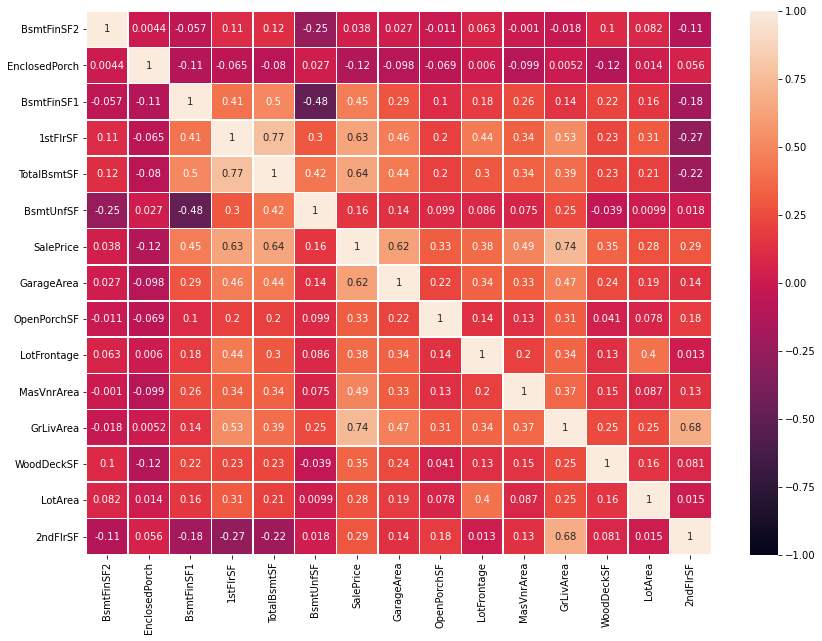

In [20]:
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, linewidths=.5, annot=True)

In [21]:
# Remove features with low correlation (<0.01) with the target variable(SalePrice)
corr_matrix['SalePrice'].abs().sort_values(ascending=False)

SalePrice        1.000000
GrLivArea        0.736036
TotalBsmtSF      0.642354
1stFlrSF         0.634672
GarageArea       0.621900
MasVnrArea       0.486620
BsmtFinSF1       0.454087
LotFrontage      0.382420
WoodDeckSF       0.350127
OpenPorchSF      0.326489
2ndFlrSF         0.293338
LotArea          0.275066
BsmtUnfSF        0.159724
EnclosedPorch    0.117988
BsmtFinSF2       0.038346
Name: SalePrice, dtype: float64

<p>if the correlation is very low (less than 0.01) consider removing it</p>
<p>consider taking the log10(y) and log10(x) (for those x that have abs(skew) > 0.6)</p>
<p>consider researching categorical variables using group by</p>

#### Checking for Normality: Dependent Variable

variable = y
Median: 159000.0
Mean: 175567.64318276005
Skew: 1.7453580480340125
Kurtosis: 5.825763749688768
--------------------------------------------------
variable = log10(y)
Median: 5.201397124320452
Mean: 5.244444479212366
Skew: 0.24188453291963574
Kurtosis: 0.7653528688452214


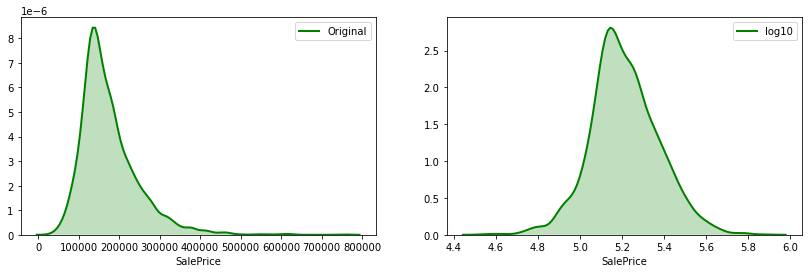

In [22]:
# Check Target variable for normal distribution
print('variable = y')
print("Median: " + str(dataset_encoded['SalePrice'].median()))
print("Mean: " + str(dataset_encoded['SalePrice'].mean()))
print("Skew: " + str(dataset_encoded['SalePrice'].skew()))
print("Kurtosis: " + str(dataset_encoded['SalePrice'].kurtosis()))
print("-"*50)
# log10
print("variable = log10(y)")
print("Median: " + str(np.log10(dataset_encoded['SalePrice'].median())))
print("Mean: " + str(np.log10(dataset_encoded['SalePrice'].mean())))
print("Skew: " + str(np.log10(dataset_encoded['SalePrice'].skew())))
print("Kurtosis: " + str(np.log10(dataset_encoded['SalePrice'].kurtosis())))
# creating axes to draw plots 
fig, ax = plt.subplots(1, 2, figsize=(14,4)) 
sns.distplot(dataset_encoded['SalePrice'], hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Original", color ="green", ax = ax[0]) 
sns.distplot(np.log10(dataset_encoded['SalePrice']), hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "log10", color ="green", ax = ax[1])


<b>Conclusion:</b> Calculating the log10 of the target variable produces a distribution closer to the normal distribution.

#### Checking for Normality: Independent Variables

In [23]:
# Continues variables with skewness greater than 0.5
(dataset_encoded[continues_variables_updated]).skew().abs()#.sort_values(ascending=False)

BsmtFinSF2        3.924373
EnclosedPorch     4.096770
BsmtFinSF1        0.746737
1stFlrSF          1.043301
TotalBsmtSF       0.456386
BsmtUnfSF         0.978891
SalePrice         1.745358
GarageArea        0.192519
OpenPorchSF       2.269634
LotFrontage       1.137594
MasVnrArea        2.750254
GrLivArea         0.940956
WoodDeckSF        1.884156
LotArea          13.393921
2ndFlrSF          0.804118
dtype: float64

In [58]:
(np.log10(dataset_encoded[continues_variables_updated]+1)).skew().abs()#.sort_values(ascending=False)

BsmtFinSF2       2.272369
EnclosedPorch    1.928748
BsmtFinSF1       0.738851
1stFlrSF         0.024600
TotalBsmtSF      4.948562
BsmtUnfSF        2.129723
SalePrice        0.155859
GarageArea       3.738757
OpenPorchSF      0.000086
LotFrontage      1.112926
MasVnrArea       0.586703
GrLivArea        0.036984
WoodDeckSF       0.156027
LotArea          0.513180
2ndFlrSF         0.269066
dtype: float64

In [25]:
columns_to_log = ['SalePrice', 'LotFrontage', 'EnclosedPorch','1stFlrSF', 'BsmtFinSF1', 'WoodDeckSF', 'LotArea',
                  'MasVnrArea', 'GrLivArea', 'OpenPorchSF', '2ndFlrSF', 'BsmtFinSF2']`

In [66]:
not ((dataset['EnclosedPorch']==0).any())

False

In [26]:
for feature in columns_to_log:
    if (not ((dataset['EnclosedPorch']==0).any())):
        dataset[feature] = np.log10(dataset[feature]+1)

In [27]:
dataset[columns_to_log]

,SalePrice,LotFrontage,EnclosedPorch,1stFlrSF,BsmtFinSF1,WoodDeckSF,LotArea,MasVnrArea,GrLivArea,OpenPorchSF,2ndFlrSF,BsmtFinSF2
0,5.100374,1.812913,0.000000,2.932981,2.378398,0.000000,3.897132,0.000000,2.932981,0.000000,0.000000,0.000000
1,5.144577,1.633468,0.000000,3.021189,2.742725,0.000000,3.626956,2.176091,3.021189,2.025306,0.000000,2.595496
2,5.096566,1.785330,1.633468,3.000868,2.868056,2.190332,3.782544,0.000000,3.000868,0.000000,0.000000,0.000000
3,5.056909,1.908485,2.227887,2.856124,0.000000,0.000000,3.910998,0.000000,3.017033,0.000000,2.509203,0.000000
4,5.356028,1.851258,0.000000,2.909021,2.808886,0.000000,3.924331,0.000000,3.221675,1.662758,2.932474,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2574,5.082789,1.826075,0.000000,2.979093,0.000000,0.000000,3.947189,0.000000,2.979093,1.995635,0.000000,0.000000
2575,5.144889,1.875061,0.000000,3.239049,0.000000,0.000000,4.136118,0.000000,3.239049,0.000000,0.000000,0.000000
2576,5.161371,1.919078,0.000000,3.000868,2.454845,0.000000,3.797337,0.000000,3.301681,0.000000,3.000868,0.000000
2577,5.337461,1.857332,0.000000,2.993877,2.925312,2.287802,3.945813,2.161368,3.265525,1.986772,2.933487,0.000000


In [ ]:
sns.distplot((dataset_encoded[dataset_encoded['LotFrontage']>0]['LotFrontage']))

In [ ]:
dataset_encoded[continues_variables].mean()
for feature in continues_variables:
    print(feature)
    print("Median: " + str((dataset_encoded[feature]+1).median()))
    print("Mean: " + str((dataset_encoded[feature]+1).mean()))
    print("Skew: " + str((dataset_encoded[feature]+1).skew()))
    print("Kurtosis: " + str((dataset_encoded[feature]+1).kurtosis()))
    print("-"*50)

#### Applying Boxcox 

In [ ]:
# generate non-normal data (exponential) 
# original_data = np.random.exponential(size = 1000) 
original_data = dataset_encoded['LotFrontage'] 
  
# transform training data & save lambda value 
fitted_data, fitted_lambda = stats.boxcox(original_data) 
  
# creating axes to draw plots 
fig, ax = plt.subplots(1, 3) 
  
# plotting the original data(non-normal) and  
# fitted data (normal) 
sns.distplot(original_data, hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Original", color ="green", ax = ax[0]) 
  
sns.distplot(fitted_data, hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Boxcox", color ="green", ax = ax[1]) 

sns.distplot(np.log10(original_data), hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Log10", color ="green", ax = ax[2])

# adding legends to the subplots 
plt.legend(loc = "upper right") 
  
# rescaling the subplots 
fig.set_figheight(5) 
fig.set_figwidth(10) 
  
print(f"Lambda value used for Transformation: {fitted_lambda}")

In [ ]:
#sns.boxplot(dataset_encoded[continues_variables[1]])
dataset_encoded[continues_variables[1]].describe()

In [ ]:
dataset_encoded[continues_variables[1]].sort_values().tail(10)

In [ ]:
dataset_encoded[dataset_encoded['LotArea']<80000]['LotArea'].skew()

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### Feature Selection

#### Using Lasso Regression to Select Features

In [36]:
X = dataset_encoded.drop('SalePrice',axis=1)  # features
y = dataset_encoded['SalePrice']         # target
X_norm = MinMaxScaler().fit_transform(X)      # Transform features by scaling each feature to a given range.

In [37]:
clf = LassoCV().fit(X_norm, y)
importance = np.abs(clf.coef_)


In [73]:
# importance
clf.alpha_

19.92777259020535

In [38]:
features =[]
scores = []
for i, feature in enumerate(X.columns):
    if importance[i]>0:
        features.append(feature)
        scores.append(importance[i])
        


In [39]:
feature_score = pd.DataFrame.from_dict({"feature":features,"Score":scores})

In [89]:
pd.set_option('display.max_rows', None) 
feature_score.sort_values(by="feature", ascending=False)
#.head(20)['feature'])

,feature,Score
40,YrSold,1130.940360
8,YearRemodAdd,2922.159137
7,YearBuilt,38890.218151
36,WoodDeckSF,8228.679288
18,TotalBsmtSF,50723.041463
28,TotRmsAbvGrd,252.926210
56,Street_Pave,205.168568
113,SaleType_WD,778.279118
112,SaleType_Con,4928.227905
111,SaleType_CWD,256.636323


In [80]:
num_f = 20 # number of features to select
# SelectFromModel -> Meta-transformer for selecting features based on importance weights.
embeded_lr_selector = SelectFromModel(Lasso(alpha=0.00001), max_features=num_f)
# embeded_lr_selector = SelectFromModel(LassoCV(cv=5), max_features=num_f)
# Penalty="l1" -> indicates regularization using L1
embeded_lr_selector.fit(X_norm, y) # Fit the SelectFromModel meta-transformer.

embeded_lr_support = embeded_lr_selector.get_support() # Get a mask, or integer index, of the features selected
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist() # List of features
print(str(len(embeded_lr_feature)), 'selected features')

20 selected features


In [81]:
# embeded_lr_feature
# list_features = [x[0:(x.find("_"))] for x in embeded_lr_feature]
list_features = []
for column_name in embeded_lr_feature:
    if '_' in column_name:
        list_features.append(column_name[0:column_name.find("_")])
    else:
        list_features.append(column_name)


In [82]:
embeded_lr_feature

['GrLivArea',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 '1stFlrSF',
 '2ndFlrSF',
 'GarageType_None',
 'Exterior2nd_PreCast',
 'MSSubClass_150',
 'RoofMatl_Membran',
 'RoofMatl_WdShngl',
 'Heating_OthW',
 'Neighborhood_e',
 'Neighborhood_f',
 'Condition2_PosA',
 'Condition2_PosN']

In [ ]:
list_feat = set(list_features)

In [ ]:
dataset[list_feat].dtypes.sort_values()

In [ ]:
list(list_feat)

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

### Descriptive Modeling

#### Train and Test data

In [44]:
# Split data 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#### Multiple Linear Regression (All the variables)

In [45]:
mlr_model = LinearRegression()
mlr_model.fit(X_train,np.log(y_train))

LinearRegression()

In [46]:
mlr_model.score(X_train,np.log(y_train))

0.949110294741936

In [47]:
# Overfitting when using all the features to train the model
mlr_model.score(X_test,np.log(y_test))

0.9368134161995757

In [48]:
X_train.columns.size

177

<hr>

#### Linear Model with limited variables

In [ ]:
temp_col = ['Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide','Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_Greens','Neighborhood_GrnHill', 'Neighborhood_IDOTRR', 'Neighborhood_Landmrk',
 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes','Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU','Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker'] + ['GrLivArea','LotArea','OverallQual','OverallCond','TotalBsmtSF','YearBuilt',]

In [ ]:
X.filter(like="MSSubClass").columns.tolist() 

In [ ]:
# X_train.filter(like="Neighborhood").columns.tolist() 
# X_train.filter(like="Condition2").columns.tolist()
# temp_col = ['1stFlrSF','OverallQual','LotArea','BsmtFinSF1','GrLivArea']
# temp_col = ['1stFlrSF','LotArea','BsmtFinSF1','GrLivArea']
# pd.concat(X_train[['1stFlrSF','OverallQual','LotArea','BsmtFinSF1','GrLivArea']],X_train.filter(like="Neighborhood"),X_train.filter(like="Condition2"))


In [53]:
temp_col = ['GrLivArea',
 'Condition2_PosA',
 'OverallQual',
 'LotArea',
 'MasVnrArea',
 'RoofMatl_WdShngl',
 'TotalBsmtSF',
 'BsmtFinSF1',
 'OverallCond',
 'YearBuilt',
 'Neighborhood_f',
 'Neighborhood_d',
 'Neighborhood_e',
 'LotFrontage',
 'BedroomAbvGr',
 'Neighborhood_c',
 #'KitchenQual',
 'Condition2_PosN',
 'BsmtCond',
 'Functional']

In [54]:
# mlr_model.fit(X[temp_col], np.log10(y))
mlr_model.fit(X_train[temp_col], np.log10(y_train))
mlr_model.score(X_train[temp_col], np.log10(y_train))

0.9162252048482903

In [55]:
mlr_model.score(X_test[temp_col], np.log10(y_test))

0.9194327504677804

In [ ]:
mlr_model.coef_

In [57]:
10**0.034020

1.0814837543185924

In [56]:
for i, name_c in enumerate(temp_col):
    print(name_c +":  " + "{:.6f}". format(mlr_model.coef_[i]))

GrLivArea:  0.000145
Condition2_PosA:  0.012766
OverallQual:  0.034020
LotArea:  0.000001
MasVnrArea:  -0.000001
RoofMatl_WdShngl:  0.039034
TotalBsmtSF:  0.000047
BsmtFinSF1:  0.000042
OverallCond:  0.021834
YearBuilt:  0.001128
Neighborhood_f:  -0.075084
Neighborhood_d:  -0.036357
Neighborhood_e:  -0.047981
LotFrontage:  0.000533
BedroomAbvGr:  -0.010668
Neighborhood_c:  -0.012096
Condition2_PosN:  -0.000000
BsmtCond:  0.002246
Functional:  0.007135


In [ ]:
# y = beta0 + beta1*X1 + beta2*X2 + beta3*X3 + betaa4*X4 ...+ betan*Xn(Exterior Quality)

<hr>

#### Adding one categorical feature (example)

In [ ]:
# adding Kitchen Quality
temp_col_k = ['1stFlrSF','OverallQual','LotArea','BsmtFinSF1','GrLivArea','KitchenQual']

In [ ]:
mlr_model.fit(X[temp_col_k], np.log(y))
mlr_model.score(X_train[temp_col_k], np.log(y_train))

In [ ]:
mlr_model.score(X_test[temp_col_k], np.log(y_test))

In [ ]:
X_test[temp_col_k].columns

In [ ]:
mlr_model.coef_

In [ ]:
mlr_model.score

<hr>

### Example (Khamanna)

In [ ]:
dataset['Year.Diff'] = dataset['YrSold']- dataset['YearRemodAdd']
within = pd.DataFrame(dataset[dataset['Year.Diff']<=10].groupby('Neighborhood')['SalePrice'].mean())
print(within)
out = pd.DataFrame(dataset[dataset['Year.Diff']>10].groupby('Neighborhood')['SalePrice'].mean())
print(out)
RemodelDif = pd.merge(within, out, left_on='Neighborhood', right_on = "Neighborhood", how='outer').reset_index()
RemodelDif.columns=['Neighborhood','SoldAfterRemodel','SoldWithoutRemodel']
RemodelDif1 = RemodelDif.drop(RemodelDif.index[[0,16,25,26,27]]).set_index('Neighborhood').sort_values(by = "SoldAfterRemodel", axis=0, ascending = False)
print(RemodelDif1)
RemodelDif1.plot(kind='barh', figsize=(10,10))

### Evaluating Overall Quality, Fence, Roof, and Garage features

In [ ]:
#Overall- Ariel
# 'OverallQual', 'OverallCond', 'PavedDrive', 'Fence'
# 'RoofStyle', 'RoofMatl','GarageFinish', 'GarageQual', 'GarageCond'

<p><strong>House Overall Quality</strong></p>
<p>Rates the overall material and finish of the house</p>
<p>&nbsp;</p>
<table style="height: 189px; width: 220px;">
<tbody>
<tr>
<th style="width: 62px; text-align: center;">Rank</th>
<th style="width: 142px; text-align: center;">Quality</th>
</tr>
<tr>
<td style="width: 62px;">10</td>
<td style="width: 142px;">Very Excellent</td>
</tr>
<tr>
<td style="width: 62px;">9</td>
<td style="width: 142px;">Excellent</td>
</tr>
<tr>
<td style="width: 62px;">8</td>
<td style="width: 142px;">Very Good</td>
</tr>
<tr>
<td style="width: 62px;">7</td>
<td style="width: 142px;">Good</td>
</tr>
<tr>
<td style="width: 62px;">6</td>
<td style="width: 142px;">Above Average</td>
</tr>
<tr>
<td style="width: 62px;">5</td>
<td style="width: 142px;">Average</td>
</tr>
<tr>
<td style="width: 62px;">4</td>
<td style="width: 142px;">Below Average</td>
</tr>
<tr>
<td style="width: 62px;">3</td>
<td style="width: 142px;">Fair</td>
</tr>
<tr>
<td style="width: 62px;">2</td>
<td style="width: 142px;">Poor</td>
</tr>
<tr>
<td style="width: 62px;">1</td>
<td style="width: 142px;">Very Poor</td>
</tr>
</tbody>
</table>

#### Linear Model

In [ ]:
# Exter
X.

In [ ]:
# adding OverallQual
# temp_col_k = ['1stFlrSF','OverallQual','LotArea','BsmtFinSF1','GrLivArea']
# temp_col_k = ['LotArea', 'GrLivArea',  'BsmtFinSF1', '1stFlrSF', 'PoolArea', 'PoolQC',
#              'Neighborhood_GrnHill', 'Condition2_PosA', 'Condition2_PosN']
temp_col_k = ['GrLivArea',
 'LotArea',
 'YearBuilt',
 '1stFlrSF',
 'PoolArea',
 'PoolQC',
 'MSSubClass_150',
 'Neighborhood_GrnHill',
 'Condition2_PosA',
 'Condition2_PosN']

In [ ]:
mlr_model.fit(X[temp_col_k], y)
mlr_model.score(X_train[temp_col_k], y_train)

In [ ]:
mlr_model.score(X_test[temp_col_k], y_test)

In [ ]:
mlr_model.coef_

In [ ]:
for i, name_c in enumerate(temp_col_k):
    print(name_c +" - " + "{:.4f}". format(mlr_model.coef_[i]))

In [ ]:
y_hat = mlr_model.predict(X_test[temp_col_k])

In [ ]:
(y_test - y_hat).sum()/y_test.shape[0]

In [ ]:
# Quality of the houses by Neighborhood
houses_neighborhood = pd.DataFrame(dataset.groupby('Neighborhood').size())
qual_neighborhood = pd.DataFrame(dataset.groupby(['Neighborhood', 'OverallQual']).size()).reset_index()
qual_neighborhood = qual_neighborhood.merge(houses_neighborhood, on="Neighborhood", how="left")
qual_neighborhood['Percentage'] = (qual_neighborhood['Obs'] / qual_neighborhood[0] * 100).round(2)

In [ ]:
qual_neighborhood[['Neighborhood','OverallQual','Percentage']]

In [ ]:
N = 5
menMeans = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
menStd = (2, 3, 4, 1, 2)
womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, menMeans, width, yerr=menStd)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans, yerr=womenStd)

plt.ylabel('Scores')
plt.title('Scores by group and gender')
plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()

In [ ]:
N = 5
menMeans = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
menStd = (2, 3, 4, 1, 2)
womenStd = (3, 5, 2, 3, 3)
ind = np.arange(len(qual_neighborhood))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, menMeans, width)
p2 = plt.bar(ind, womenMeans, width)

plt.ylabel('Scores')
plt.title('Scores by group and gender')
plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()

In [ ]:
len(qual_neighborhood['Neighborhood'].unique())
np.array(stacked_bar_values).reshape(28,10)
#qual_neighborhood
stacked_bar_values = []
for neighborhood in qual_neighborhood['Neighborhood'].unique():
    print(neighborhood)
    for i in range(1,11):
        print(qual_neighborhood.loc[i])
        stacked_bar_values.append(0) 


<b>Ava: </b>'BsmtQual', 'BsmtCond','BsmtFinType1', 'BsmtFinType1', 'BsmtUnfSF', 'TotalBsmtSF'

<b>Khamanna: </b>'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'GarageFinish', GarageQual', 'GarageCond',

<b>Ariel:</b>'OverallQual', 'OverallCond', 'PavedDrive', 'Fence', 'RoofStyle', 'RoofMatl',

<b>Shay: </b>'HeatingQC', 'CentralAir', 'KitchenAbvGr', 'KitchenQual', 'Fireplaces', 'FireplaceQu', 'LowQualFinSF'
 
y = beta0 + beta1*X1 + beta2*X2 + beta3*X3 + beta4*X4 ...+ betan*Xn(Exterior Quality)

In [ ]:
# new dataset that will hold the encoded categorical variables + all the others
dataset_encoded = dataset.drop(columns=['BsmtQual', 'BsmtCond','BsmtFinType1', 'BsmtFinType1', 'BsmtUnfSF', 'TotalBsmtSF',
'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
'OverallQual', 'OverallCond', 'PavedDrive', 'Fence', 'RoofStyle', 'RoofMatl','GarageFinish',
'GarageQual', 'GarageCond','HeatingQC', 'CentralAir', 'KitchenAbvGr', 'KitchenQual',
'Fireplaces', 'FireplaceQu', 'LowQualFinSF'], axis=1).copy()

In [ ]:
# Do not run...
categorical_nominal_variables.remove('CentralAir')
categorical_nominal_variables.remove('Exterior1st')
categorical_nominal_variables.remove('Exterior2nd')
categorical_nominal_variables.remove('RoofStyle')
categorical_nominal_variables.remove('RoofMatl')
categorical_nominal_variables.remove('MasVnrType')

In [ ]:
dataset['Neighborhood'].unique()

In [ ]:
dataset['MSSubClass']